In [23]:
import yfinance as yf 
import sys
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [24]:
import torch.nn as nn


class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


model = StockLSTM()


In [25]:
def load_stock_data(ticker, start, end):
    # Ensure Yahoo Finance-compatible ticker (e.g., Brazilian stocks use .SA)
    yf_ticker = ticker if "." in ticker else f"{ticker}.SA"
    try:
        df = yf.download(yf_ticker, start=start, end=end, auto_adjust=False)[["Close"]]
    except Exception as e:
        raise RuntimeError(f"Failed to download data for {yf_ticker}: {e}")
    if df is None or df.empty:
        raise RuntimeError(f"No data returned for {yf_ticker}. Check the symbol and date range.")
    df.dropna(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

In [26]:
def scale_data(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.values)
    return scaled, scaler

In [27]:
def create_sequences(data, seq_length=50):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [28]:


def load_data( stock = "ABEV3",start: str = "2015-01-01", end: str = "2026-01-01"):
    # 1. Load stock data
    df = load_stock_data(stock, start=start, end=end)
    df.reset_index(inplace=True)

    # 2. Scale the "Close" data
    scaled_data, scaler = scale_data(df[["Close"]])
    df["ScaledClose"] = scaled_data

    # 3. Create input sequences for the model
    X_np, y_np = create_sequences(scaled_data, seq_length=50)

    # Train/test split (e.g., last 20% for test)
    split_idx = int(len(X_np) * 0.8)
    X_train, y_train = X_np[:split_idx], y_np[:split_idx]
    X_test, y_test = X_np[split_idx:], y_np[split_idx:]

    # 4. Convert to PyTorch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)

    # 5. Setup DataLoader
    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 6. Define model, loss, optimizer
    model = StockLSTM(input_size=1, hidden_size=64, num_layers=2)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 7. Train the model
    loss_history = []
    model.train()
    for epoch in range(100):
        epoch_loss = 0.0
        for X_batch, y_batch in loader:
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)

    # 8. Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t).numpy()
        y_true_test = y_test_t.numpy()

    # Inverse transform predictions and truths
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)
    y_true_test_inv = scaler.inverse_transform(y_true_test)

    # Metrics
    mse = float(np.mean((y_true_test - y_pred_test) ** 2))
    mae = float(np.mean(np.abs(y_true_test - y_pred_test)))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs((y_true_test - y_pred_test) / np.clip(y_true_test, 1e-8, None))) * 100)
    # R2 on scaled values
    ss_res = np.sum((y_true_test - y_pred_test) ** 2)
    ss_tot = np.sum((y_true_test - np.mean(y_true_test)) ** 2)
    r2 = float(1 - ss_res / ss_tot) if ss_tot > 0 else float("nan")

    # 9. Predict the next price using last sequence
    with torch.no_grad():
        last_seq = torch.tensor(scaled_data[-50:], dtype=torch.float32).unsqueeze(0)
        predicted_next_scaled = model(last_seq).numpy()
        predicted_next_price = scaler.inverse_transform(predicted_next_scaled)[0][0]

    return {
        "loss_history": [float(l) for l in loss_history],
        "predicted_next_price": float(predicted_next_price),
        "y_true_scaled": y_true_test.squeeze().tolist(),
        "y_pred_scaled": y_pred_test.squeeze().tolist(),
        "y_true": y_true_test_inv.squeeze().tolist(),
        "y_pred": y_pred_test_inv.squeeze().tolist(),
        "metrics": {
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE_%": mape,
            "R2": r2
        },
        "model": model,
        "scaler": scaler
    }

In [29]:
results = load_data(stock="ABEV3.SA", start="2020-01-01", end="2024-12-31")
print("Training completed!")
print("Metrics:")
for k, v in results["metrics"].items():
    print(f"  {k}: {v:.6f}")
print(f"Predicted next price: R$ {results['predicted_next_price']:.2f}")

[*********************100%***********************]  1 of 1 completed


Training completed!
Metrics:
  MSE: 0.000506
  MAE: 0.015680
  RMSE: 0.022486
  MAPE_%: 14.343580
  R2: 0.913654
Predicted next price: R$ 11.96


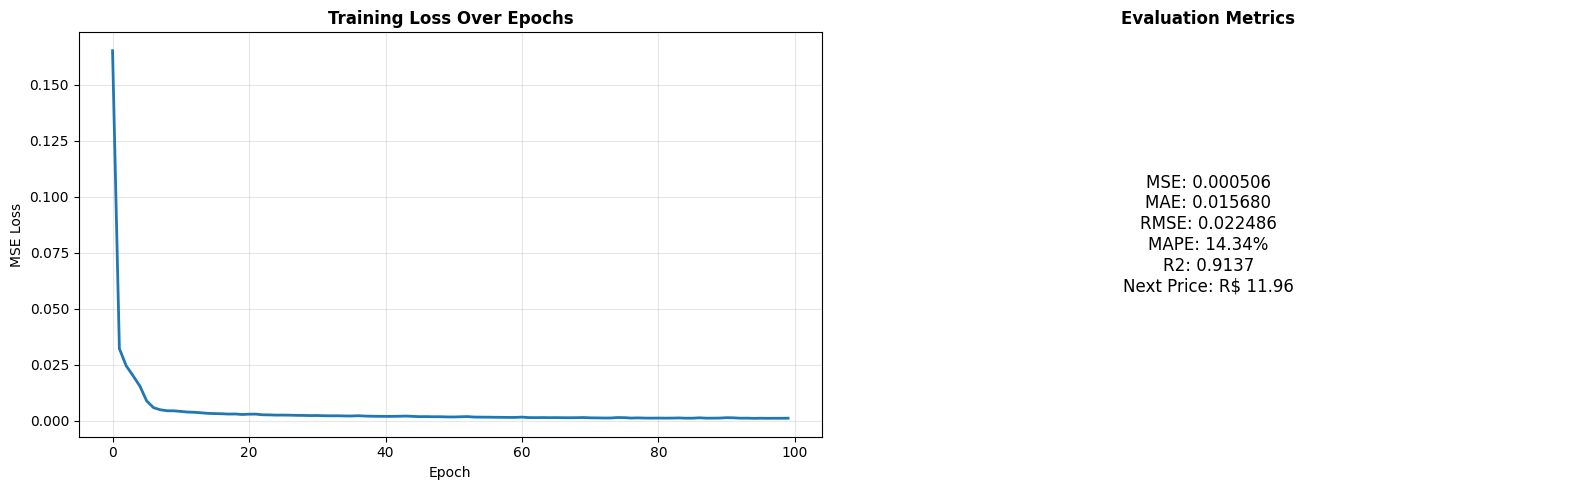

In [30]:
# Plot training loss
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[0].plot(results['loss_history'], linewidth=2)
ax[0].set_title('Training Loss Over Epochs', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE Loss')
ax[0].grid(True, alpha=0.3)

# Metrics summary text
m = results['metrics']
metrics_text = (f"MSE: {m['MSE']:.6f}\n"
                f"MAE: {m['MAE']:.6f}\n"
                f"RMSE: {m['RMSE']:.6f}\n"
                f"MAPE: {m['MAPE_%']:.2f}%\n"
                f"R2: {m['R2']:.4f}\n"
                f"Next Price: R$ {results['predicted_next_price']:.2f}")
ax[1].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12)
ax[1].set_title('Evaluation Metrics', fontsize=12, fontweight='bold')
ax[1].axis('off')

plt.tight_layout()
plt.show()

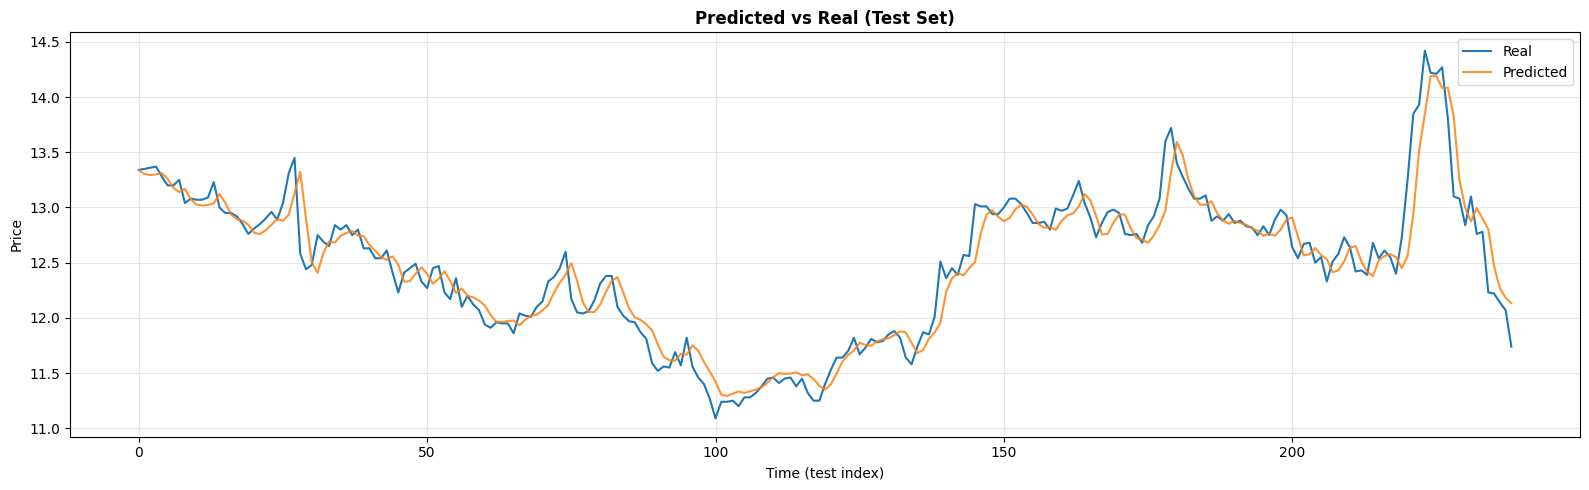

In [31]:
fig, axes = plt.subplots( figsize=(16, 5))

axes.plot(results['y_true'], label='Real', color='tab:blue')
axes.plot(results['y_pred'], label='Predicted', color='tab:orange', alpha=0.85)
axes.set_title('Predicted vs Real (Test Set)', fontsize=12, fontweight='bold')
axes.set_xlabel('Time (test index)')
axes.set_ylabel('Price')
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [ ]:
# import os, joblib
# os.makedirs("models", exist_ok=True)
# torch.save(results["model"].state_dict(), "models/stock_lstm.pt")
# joblib.dump(results["scaler"], "models/scaler.joblib")
# print("Saved models:", "models/stock_lstm.pt", "models/scaler.joblib")

# IBOV TESTING


In [33]:
# Test all stocks from CSV
import time

# Load tickers from CSV
tickers_df = pd.read_csv("../data/ibov_tickers.csv")
tickers = tickers_df['codigo'].tolist()

# print(f"Total tickers to test: {len(tickers)}")
# print(f"Tickers: {tickers[:10]}... (showing first 10)")


In [ ]:
# Run model for all tickers and collect results
all_results = []
failed_tickers = []

for i, ticker in enumerate(tickers, 1):
    print(f"\n[{i}/{len(tickers)}] Processing {ticker}...")
    
    try:
        # Add .SA suffix for Brazilian stocks
        ticker_full = ticker if "." in ticker else f"{ticker}.SA"
        
        # Train model for this ticker
        result = load_data(stock=ticker_full, start="2020-01-01", end="2024-12-31")
        
        # Store results with ticker info
        result['ticker'] = ticker
        result['ticker_full'] = ticker_full
        all_results.append(result)
        
        # Print summary
        metrics = result['metrics']
        print(f"✓ {ticker}: R2={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.4f}, Next Price=R$ {result['predicted_next_price']:.2f}")
        
    except Exception as e:
        print(f"✗ {ticker}: Failed - {str(e)[:100]}")
        failed_tickers.append({'ticker': ticker, 'error': str(e)})
    
    # Small delay to avoid overloading Yahoo Finance
    time.sleep(0.5)

print(f"\n{'='*60}")
print(f"Completed: {len(all_results)} successful, {len(failed_tickers)} failed")


[*********************100%***********************]  1 of 1 completed


[1/82] Processing ALOS3...


✓ ALOS3: R2=0.9553, RMSE=0.0084, Next Price=R$ 18.21


[*********************100%***********************]  1 of 1 completed


[2/82] Processing ABEV3...


✓ ABEV3: R2=0.9272, RMSE=0.0206, Next Price=R$ 11.82


[*********************100%***********************]  1 of 1 completed


[3/82] Processing ASAI3...


✓ ASAI3: R2=0.8768, RMSE=0.0550, Next Price=R$ 7.06


[*********************100%***********************]  1 of 1 completed


[4/82] Processing AURE3...


✓ AURE3: R2=0.9459, RMSE=0.0309, Next Price=R$ 9.09


[*********************100%***********************]  1 of 1 completed


[5/82] Processing AXIA3...


✓ AXIA3: R2=0.9478, RMSE=0.0172, Next Price=R$ 34.48


[*********************100%***********************]  1 of 1 completed


[6/82] Processing AXIA6...


✓ AXIA6: R2=0.9337, RMSE=0.0202, Next Price=R$ 38.22


[*********************100%***********************]  1 of 1 completed


[7/82] Processing AZZA3...


✓ AZZA3: R2=0.9507, RMSE=0.0239, Next Price=R$ 32.03


[*********************100%***********************]  1 of 1 completed


[8/82] Processing B3SA3...


✓ B3SA3: R2=0.9304, RMSE=0.0205, Next Price=R$ 10.58


[*********************100%***********************]  1 of 1 completed


[9/82] Processing BBSE3...


✓ BBSE3: R2=0.9015, RMSE=0.0225, Next Price=R$ 35.96


[*********************100%***********************]  1 of 1 completed


[10/82] Processing BBDC3...


✓ BBDC3: R2=0.9332, RMSE=0.0156, Next Price=R$ 10.84


[*********************100%***********************]  1 of 1 completed


[11/82] Processing BBDC4...


✓ BBDC4: R2=0.9371, RMSE=0.0174, Next Price=R$ 11.77


[*********************100%***********************]  1 of 1 completed


[12/82] Processing BRAP4...


✓ BRAP4: R2=0.9404, RMSE=0.0139, Next Price=R$ 16.67


[*********************100%***********************]  1 of 1 completed


[13/82] Processing BBAS3...


✓ BBAS3: R2=0.9236, RMSE=0.0196, Next Price=R$ 24.19


[*********************100%***********************]  1 of 1 completed


[14/82] Processing BRKM5...


✓ BRKM5: R2=0.8913, RMSE=0.0163, Next Price=R$ 12.88


[*********************100%***********************]  1 of 1 completed


[15/82] Processing BRAV3...


✓ BRAV3: R2=0.9521, RMSE=0.0351, Next Price=R$ 22.84


[*********************100%***********************]  1 of 1 completed


[16/82] Processing BPAC11...


✓ BPAC11: R2=0.8622, RMSE=0.0263, Next Price=R$ 27.85


[*********************100%***********************]  1 of 1 completed


[17/82] Processing CXSE3...


✓ CXSE3: R2=0.6747, RMSE=0.0393, Next Price=R$ 14.69


[*********************100%***********************]  1 of 1 completed


[18/82] Processing CEAB3...


✓ CEAB3: R2=0.8759, RMSE=0.0307, Next Price=R$ 8.39


[*********************100%***********************]  1 of 1 completed


[19/82] Processing CMIG4...


✓ CMIG4: R2=0.9363, RMSE=0.0304, Next Price=R$ 10.85


[*********************100%***********************]  1 of 1 completed


[20/82] Processing COGN3...


✓ COGN3: R2=0.9189, RMSE=0.0128, Next Price=R$ 1.26


[*********************100%***********************]  1 of 1 completed


[21/82] Processing CPLE5...


✓ CPLE5: R2=0.9818, RMSE=0.0121, Next Price=R$ 9.92


[*********************100%***********************]  1 of 1 completed


[22/82] Processing CSAN3...


✓ CSAN3: R2=0.9333, RMSE=0.0333, Next Price=R$ 9.38


[*********************100%***********************]  1 of 1 completed


[23/82] Processing CPFE3...


✓ CPFE3: R2=0.8873, RMSE=0.0269, Next Price=R$ 31.71


[*********************100%***********************]  1 of 1 completed


[24/82] Processing CMIN3...


✓ CMIN3: R2=0.8477, RMSE=0.0284, Next Price=R$ 5.10


[*********************100%***********************]  1 of 1 completed


[25/82] Processing CURY3...


✓ CURY3: R2=0.8984, RMSE=0.0325, Next Price=R$ 17.75


[*********************100%***********************]  1 of 1 completed


[26/82] Processing CVCB3...


✓ CVCB3: R2=0.9586, RMSE=0.0031, Next Price=R$ 1.41


[*********************100%***********************]  1 of 1 completed


[27/82] Processing CYRE3...


✓ CYRE3: R2=0.9275, RMSE=0.0215, Next Price=R$ 17.06


[*********************100%***********************]  1 of 1 completed


[28/82] Processing DIRR3...


✓ DIRR3: R2=0.9629, RMSE=0.0224, Next Price=R$ 8.88


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EMBJ3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577847600, endDate = 1735614000")')



[29/82] Processing EMBJ3...
✗ EMBJ3: Failed - No data returned for EMBJ3.SA. Check the symbol and date range.


[*********************100%***********************]  1 of 1 completed


[30/82] Processing ENGI11...


✓ ENGI11: R2=0.9433, RMSE=0.0333, Next Price=R$ 33.67


[*********************100%***********************]  1 of 1 completed


[31/82] Processing ENEV3...


✓ ENEV3: R2=0.9251, RMSE=0.0175, Next Price=R$ 10.59


[*********************100%***********************]  1 of 1 completed


[32/82] Processing EGIE3...


✓ EGIE3: R2=0.9615, RMSE=0.0262, Next Price=R$ 25.53


[*********************100%***********************]  1 of 1 completed


[33/82] Processing EQTL3...


✓ EQTL3: R2=0.8956, RMSE=0.0302, Next Price=R$ 27.49


[*********************100%***********************]  1 of 1 completed


[34/82] Processing FLRY3...


✓ FLRY3: R2=0.9282, RMSE=0.0139, Next Price=R$ 12.45

[35/82] Processing GGBR4...


[*********************100%***********************]  1 of 1 completed


✓ GGBR4: R2=0.8423, RMSE=0.0156, Next Price=R$ 18.32


[*********************100%***********************]  1 of 1 completed


[36/82] Processing GOAU4...


✓ GOAU4: R2=0.8103, RMSE=0.0168, Next Price=R$ 10.28


[*********************100%***********************]  1 of 1 completed


[37/82] Processing HAPV3...


✓ HAPV3: R2=0.8748, RMSE=0.0118, Next Price=R$ 36.55


[*********************100%***********************]  1 of 1 completed


[38/82] Processing HYPE3...


✓ HYPE3: R2=0.9531, RMSE=0.0274, Next Price=R$ 19.72


[*********************100%***********************]  1 of 1 completed


[39/82] Processing IGTI11...


✓ IGTI11: R2=0.9210, RMSE=0.0411, Next Price=R$ 17.58


[*********************100%***********************]  1 of 1 completed


[40/82] Processing IRBR3...


✓ IRBR3: R2=0.8684, RMSE=0.0020, Next Price=R$ 40.96


[*********************100%***********************]  1 of 1 completed


[41/82] Processing ISAE4...


✓ ISAE4: R2=0.8459, RMSE=0.0321, Next Price=R$ 22.96


[*********************100%***********************]  1 of 1 completed


[42/82] Processing ITSA4...


✓ ITSA4: R2=0.9290, RMSE=0.0235, Next Price=R$ 8.79

[43/82] Processing ITUB4...


[*********************100%***********************]  1 of 1 completed


✓ ITUB4: R2=0.9413, RMSE=0.0236, Next Price=R$ 27.95


[*********************100%***********************]  1 of 1 completed


[44/82] Processing KLBN11...


✓ KLBN11: R2=0.8747, RMSE=0.0215, Next Price=R$ 22.96


[*********************100%***********************]  1 of 1 completed


[45/82] Processing RENT3...


✓ RENT3: R2=0.9007, RMSE=0.0382, Next Price=R$ 33.52

[46/82] Processing LREN3...


[*********************100%***********************]  1 of 1 completed


✓ LREN3: R2=0.8913, RMSE=0.0144, Next Price=R$ 11.98


[*********************100%***********************]  1 of 1 completed


[47/82] Processing MGLU3...


✓ MGLU3: R2=0.9296, RMSE=0.0043, Next Price=R$ 6.21


[*********************100%***********************]  1 of 1 completed


[48/82] Processing POMO4...


✓ POMO4: R2=0.9242, RMSE=0.0320, Next Price=R$ 7.24


[*********************100%***********************]  1 of 1 completed


[49/82] Processing MBRF3...


✓ MBRF3: R2=0.9710, RMSE=0.0228, Next Price=R$ 17.04


[*********************100%***********************]  1 of 1 completed


[50/82] Processing BEEF3...


✓ BEEF3: R2=0.8468, RMSE=0.0209, Next Price=R$ 5.44


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MOTV3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1577847600, endDate = 1735614000")')



[51/82] Processing MOTV3...
✗ MOTV3: Failed - No data returned for MOTV3.SA. Check the symbol and date range.


[*********************100%***********************]  1 of 1 completed


[52/82] Processing MRVE3...


✓ MRVE3: R2=0.9136, RMSE=0.0124, Next Price=R$ 5.43


[*********************100%***********************]  1 of 1 completed


[53/82] Processing MULT3...


✓ MULT3: R2=0.9367, RMSE=0.0210, Next Price=R$ 21.13


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NATU3.SA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2024-12-31)')



[54/82] Processing NATU3...
✗ NATU3: Failed - No data returned for NATU3.SA. Check the symbol and date range.


[*********************100%***********************]  1 of 1 completed


[55/82] Processing PCAR3...


✓ PCAR3: R2=0.0942, RMSE=0.0107, Next Price=R$ 2.12


[*********************100%***********************]  1 of 1 completed


[56/82] Processing PETR3...


✓ PETR3: R2=0.7578, RMSE=0.0282, Next Price=R$ 38.89


[*********************100%***********************]  1 of 1 completed


[57/82] Processing PETR4...


✓ PETR4: R2=0.8414, RMSE=0.0238, Next Price=R$ 35.99


[*********************100%***********************]  1 of 1 completed


[58/82] Processing RECV3...


✓ RECV3: R2=0.9542, RMSE=0.0182, Next Price=R$ 15.98


[*********************100%***********************]  1 of 1 completed


[59/82] Processing PRIO3...


✓ PRIO3: R2=0.8451, RMSE=0.0246, Next Price=R$ 39.55


[*********************100%***********************]  1 of 1 completed


[60/82] Processing PSSA3...


✓ PSSA3: R2=0.9653, RMSE=0.0320, Next Price=R$ 37.51


[*********************100%***********************]  1 of 1 completed


[61/82] Processing RADL3...


✓ RADL3: R2=0.8953, RMSE=0.0360, Next Price=R$ 22.20


[*********************100%***********************]  1 of 1 completed


[62/82] Processing RAIZ4...


✓ RAIZ4: R2=0.9031, RMSE=0.0161, Next Price=R$ 2.27


[*********************100%***********************]  1 of 1 completed


[63/82] Processing RDOR3...


✓ RDOR3: R2=0.8918, RMSE=0.0150, Next Price=R$ 25.79


[*********************100%***********************]  1 of 1 completed


[64/82] Processing RAIL3...


✓ RAIL3: R2=0.9479, RMSE=0.0281, Next Price=R$ 17.96


[*********************100%***********************]  1 of 1 completed


[65/82] Processing SBSP3...


✓ SBSP3: R2=0.9640, RMSE=0.0204, Next Price=R$ 89.12


[*********************100%***********************]  1 of 1 completed


[66/82] Processing SANB11...


✓ SANB11: R2=0.9003, RMSE=0.0196, Next Price=R$ 24.27


[*********************100%***********************]  1 of 1 completed


[67/82] Processing CSNA3...


✓ CSNA3: R2=0.9588, RMSE=0.0099, Next Price=R$ 8.57


[*********************100%***********************]  1 of 1 completed


[68/82] Processing SLCE3...


✓ SLCE3: R2=0.7598, RMSE=0.0222, Next Price=R$ 17.85


[*********************100%***********************]  1 of 1 completed


[69/82] Processing SMFT3...


✓ SMFT3: R2=0.9000, RMSE=0.0233, Next Price=R$ 17.02


[*********************100%***********************]  1 of 1 completed


[70/82] Processing SUZB3...


✓ SUZB3: R2=0.9121, RMSE=0.0247, Next Price=R$ 61.14


[*********************100%***********************]  1 of 1 completed


[71/82] Processing TAEE11...


✓ TAEE11: R2=0.8803, RMSE=0.0154, Next Price=R$ 32.75


[*********************100%***********************]  1 of 1 completed


[72/82] Processing VIVT3...


✓ VIVT3: R2=0.9429, RMSE=0.0366, Next Price=R$ 23.55


[*********************100%***********************]  1 of 1 completed


[73/82] Processing TIMS3...


✓ TIMS3: R2=0.9306, RMSE=0.0344, Next Price=R$ 14.50


[*********************100%***********************]  1 of 1 completed


[74/82] Processing TOTS3...


✓ TOTS3: R2=0.7160, RMSE=0.0284, Next Price=R$ 26.94


[*********************100%***********************]  1 of 1 completed


[75/82] Processing UGPA3...


In [ ]:
# Create summary DataFrame with all metrics
summary_data = []

for result in all_results:
    summary_data.append({
        'Ticker': result['ticker'],
        'MSE': result['metrics']['MSE'],
        'MAE': result['metrics']['MAE'],
        'RMSE': result['metrics']['RMSE'],
        'MAPE (%)': result['metrics']['MAPE_%'],
        'R²': result['metrics']['R2'],
        'Next Price (R$)': result['predicted_next_price']
    })

summary_df = pd.DataFrame(summary_data)

# Display top 10 best models (by R²)
print("="*80)
print("TOP 10 BEST MODELS (by R²)")
print("="*80)
print(summary_df.nlargest(10, 'R²').to_string(index=False))

# Display top 10 worst models (by R²)
print("\n" + "="*80)
print("TOP 10 WORST MODELS (by R²)")
print("="*80)
print(summary_df.nsmallest(10, 'R²').to_string(index=False))

# Save full results to CSV
summary_df.to_csv('../data/model_results_summary.csv', index=False)


In [ ]:
# Overall Statistics
print("="*80)
print("OVERALL STATISTICS - ALL MODELS")
print("="*80)

overall_stats = {
    'Total Stocks Tested': len(all_results),
    'Failed': len(failed_tickers),
    'Success Rate (%)': (len(all_results) / (len(all_results) + len(failed_tickers)) * 100) if (len(all_results) + len(failed_tickers)) > 0 else 0,
    'Average R²': summary_df['R²'].mean(),
    'Median R²': summary_df['R²'].median(),
    'Std Dev R²': summary_df['R²'].std(),
    'Average RMSE': summary_df['RMSE'].mean(),
    'Average MAPE (%)': summary_df['MAPE (%)'].mean(),
    'Models with R² > 0.7': (summary_df['R²'] > 0.7).sum(),
    'Models with R² > 0.8': (summary_df['R²'] > 0.8).sum(),
    'Models with R² > 0.9': (summary_df['R²'] > 0.9).sum(),
}

for key, value in overall_stats.items():
    if isinstance(value, float):
        print(f"{key:.<50} {value:.4f}")
    else:
        print(f"{key:.<50} {value}")

# Display failed tickers if any
if failed_tickers:
    print("\n" + "="*80)
    print("FAILED TICKERS")
    print("="*80)
    for fail in failed_tickers[:10]:  # Show first 10
        print(f"  {fail['ticker']}: {fail['error'][:80]}")
    if len(failed_tickers) > 10:
        print(f"  ... and {len(failed_tickers) - 10} more")


In [ ]:
# Visualizations - Overall Performance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. R² Distribution
axes[0, 0].hist(summary_df['R²'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].axvline(summary_df['R²'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {summary_df["R²"].mean():.3f}')
axes[0, 0].set_title('R² Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('R²')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. RMSE Distribution
axes[0, 1].hist(summary_df['RMSE'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(summary_df['RMSE'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {summary_df["RMSE"].mean():.4f}')
axes[0, 1].set_title('RMSE Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. MAPE Distribution
axes[0, 2].hist(summary_df['MAPE (%)'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 2].axvline(summary_df['MAPE (%)'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {summary_df["MAPE (%)"].mean():.2f}%')
axes[0, 2].set_title('MAPE (%) Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('MAPE (%)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Top 15 Stocks by R²
top15 = summary_df.nlargest(15, 'R²')
axes[1, 0].barh(top15['Ticker'], top15['R²'], color='green', alpha=0.7)
axes[1, 0].set_title('Top 15 Stocks by R²', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('R²')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 5. Bottom 15 Stocks by R²
bottom15 = summary_df.nsmallest(15, 'R²')
axes[1, 1].barh(bottom15['Ticker'], bottom15['R²'], color='red', alpha=0.7)
axes[1, 1].set_title('Bottom 15 Stocks by R²', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('R²')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

# 6. R² vs RMSE Scatter
scatter = axes[1, 2].scatter(summary_df['R²'], summary_df['RMSE'], alpha=0.6, c=summary_df['MAPE (%)'], cmap='viridis', s=50)
axes[1, 2].set_title('R² vs RMSE (colored by MAPE)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('R²')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 2], label='MAPE (%)')

plt.tight_layout()
plt.show()


In [ ]:
# Performance Categories
excellent = summary_df[summary_df['R²'] >= 0.9]
good = summary_df[(summary_df['R²'] >= 0.7) & (summary_df['R²'] < 0.9)]
fair = summary_df[(summary_df['R²'] >= 0.5) & (summary_df['R²'] < 0.7)]
poor = summary_df[summary_df['R²'] < 0.5]

print("="*80)
print("MODEL PERFORMANCE CATEGORIES")
print("="*80)
print(f"\n🟢 EXCELLENT (R² ≥ 0.9): {len(excellent)} stocks ({len(excellent)/len(summary_df)*100:.1f}%)")
if len(excellent) > 0:
    print(f"   Tickers: {', '.join(excellent['Ticker'].tolist())}")

print(f"\n🔵 GOOD (0.7 ≤ R² < 0.9): {len(good)} stocks ({len(good)/len(summary_df)*100:.1f}%)")
if len(good) > 0:
    print(f"   Tickers: {', '.join(good['Ticker'].tolist()[:20])}")
    if len(good) > 20:
        print(f"   ... and {len(good)-20} more")

print(f"\n🟡 FAIR (0.5 ≤ R² < 0.7): {len(fair)} stocks ({len(fair)/len(summary_df)*100:.1f}%)")
if len(fair) > 0:
    print(f"   Tickers: {', '.join(fair['Ticker'].tolist()[:20])}")
    if len(fair) > 20:
        print(f"   ... and {len(fair)-20} more")

print(f"\n🔴 POOR (R² < 0.5): {len(poor)} stocks ({len(poor)/len(summary_df)*100:.1f}%)")
if len(poor) > 0:
    print(f"   Tickers: {', '.join(poor['Ticker'].tolist()[:20])}")
    if len(poor) > 20:
        print(f"   ... and {len(poor)-20} more")

# Pie chart of categories
fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Excellent\n(R²≥0.9)', 'Good\n(0.7≤R²<0.9)', 'Fair\n(0.5≤R²<0.7)', 'Poor\n(R²<0.5)']
sizes = [len(excellent), len(good), len(fair), len(poor)]
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
explode = (0.05, 0, 0, 0)

ax.pie(sizes, explode=explode, labels=categories, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Model Performance Distribution', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()
